<a href="https://colab.research.google.com/github/ludwigwittgenstein2/Research/blob/master/Information_Quality_Text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Information Quality of Text

Dimensions:

1. Relevance
2. Consistency
3. Accuracy



#Gpt-2 Text Generator


In [1]:
!pip install -q gpt-2-simple
import gpt_2_simple as gpt2
from datetime import datetime
from google.colab import files


  Preparing metadata (setup.py) ... done


In [2]:
!nvidia-smi

Sat Oct 28 21:31:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

>
There are three released sizes of GPT-2:

124M (default): the "small" model, 500MB on disk.

355M: the "medium" model, 1.5GB on disk.

774M: the "large" model, cannot currently be finetuned with Colaboratory but can be used to generate text from the pretrained model (see later in Notebook)

1558M: the "extra large", true model. Will not work if a K80 GPU is attached to the notebook. (like 774M, it cannot be finetuned).


In [3]:
gpt2.download_gpt2(model_name="124M")

Fetching checkpoint: 1.05Mit [00:00, 3.84Git/s]                                                     
Fetching encoder.json: 1.05Mit [00:00, 4.45Mit/s]
Fetching hparams.json: 1.05Mit [00:00, 4.61Git/s]                                                   
Fetching model.ckpt.data-00000-of-00001: 498Mit [00:07, 65.6Mit/s]                                  
Fetching model.ckpt.index: 1.05Mit [00:00, 2.47Git/s]                                               
Fetching model.ckpt.meta: 1.05Mit [00:00, 5.89Mit/s]
Fetching vocab.bpe: 1.05Mit [00:00, 6.68Mit/s]


In [4]:
gpt2.mount_gdrive()

Mounted at /content/drive


In [21]:
file_name = "CleanedDatasetEntire1.txt"

In [22]:
gpt2.copy_file_from_gdrive(file_name)

In [24]:
sess = gpt2.start_tf_sess()

gpt2.finetune(sess,
              dataset=file_name,
              model_name='124M',
              steps=50,
              restore_from='fresh',
              run_name='run1',
              print_every=10,
              sample_every=200,
              save_every=500,
              reuse=True,
              )

Loading checkpoint models/124M/model.ckpt
Loading dataset...


100%|██████████| 1/1 [00:00<00:00, 678.03it/s]

dataset has 17233 tokens
Training...


[10 | 26.92] loss=2.46 avg=2.46
[20 | 50.09] loss=1.91 avg=2.18
[30 | 73.66] loss=1.59 avg=1.98
[40 | 96.76] loss=1.48 avg=1.86
[50 | 119.71] loss=1.36 avg=1.76
Saving checkpoint/run1/model-50


In [35]:
gpt2.copy_checkpoint_to_gdrive(run_name='run1')

In [36]:
import tensorflow as tf
tf.compat.v1.reset_default_graph()

In [37]:
sess = gpt2.start_tf_sess()
gpt2.load_gpt2(sess, run_name='run1')

Loading checkpoint checkpoint/run1/model-50


In [34]:
gpt2.generate(sess, run_name='run1', destination_path='generated_text.txt')

In [ ]:
gen_file = 'gpt2_gentext_{:%Y%m%d_%H%M%S}.txt'.format(datetime.utcnow())

gpt2.generate_to_file(sess,
                      destination_path=gen_file,
                      length=500,
                      temperature=0.7,
                      nsamples=100,
                      batch_size=20
                      )

In [39]:
single_text = gpt2.generate(sess, return_as_list=False,destination_path='synthetic_GPT_2.txt' )
print((single_text))

None


In [32]:
import csv

with open('single_text.txt', 'w') as f:
	# using csv.writer method from CSV package
	write = csv.writer(f)
	write.writerow(single_text)



In [33]:
import csv

# Open a CSV file for writing and write the text to it
with open('data.txt', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(single_text)

print("Data exported to data.txt successfully!")


Data exported to data.txt successfully!


#Evaluate Quality of Text:


KL-Divergence

The KL divergence between the two arrays is: 11.704128455529556


<ipython-input-40-ad68590a5a68>:45: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data1_array, hist=False, label='GPT-2 generated')
<ipython-input-40-ad68590a5a68>:46: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data2_array, hist=False, label='US-Census Entire Dataset')


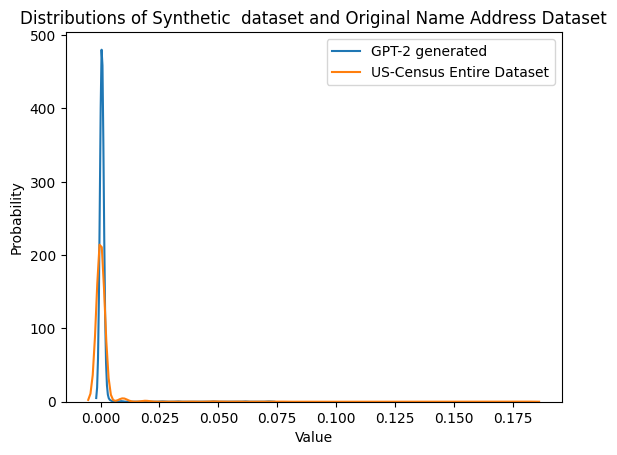

In [40]:
import csv
import numpy as np
import seaborn as sns
from scipy.stats import entropy
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

# Read the data from the first CSV file
with open('/content/CleanedDatasetEntire1.txt', 'r') as file1:
    reader1 = csv.reader(file1)
    data1 = [row[0] for row in reader1]

# Read the data from the second CSV file
with open('/content/single_text.txt', 'r') as file2:
    reader2 = csv.reader(file2)
    data2 = [row[0] for row in reader2]

# Convert the strings into a vector representation
vectorizer = CountVectorizer()
data1_vector = vectorizer.fit_transform(data1)
data2_vector = vectorizer.transform(data2)

# Convert the vector representation into a numpy array
data1_array = data1_vector.toarray().sum(axis=0)
data2_array = data2_vector.toarray().sum(axis=0)

# Normalize the arrays
data1_array = data1_array / data1_array.sum()
data2_array = data2_array / data2_array.sum()

# Add a small constant to all elements
data1_array = data1_array + 1e-10
data2_array = data2_array + 1e-10

# Normalize the arrays again
data1_array = data1_array / data1_array.sum()
data2_array = data2_array / data2_array.sum()

# Calculate the KL divergence between the two arrays
kl_divergence = entropy(data1_array, data2_array)

print("The KL divergence between the two arrays is:", kl_divergence)

# Plot the arrays using seaborn
sns.distplot(data1_array, hist=False, label='GPT-2 generated')
sns.distplot(data2_array, hist=False, label='US-Census Entire Dataset')
plt.xlabel('Value')
plt.ylabel('Probability')
plt.title('Distributions of Synthetic  dataset and Original Name Address Dataset')
plt.legend()
plt.show()


#Cosine

In [41]:
import math
import string
from collections import Counter

def read_file(file_name):
    with open(file_name, 'r') as file:
        return file.read()

def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

def get_cosine_similarity(text1, text2):
    text1 = clean_text(text1)
    text2 = clean_text(text2)

    words1 = text1.split()
    words2 = text2.split()

    word_counts1 = Counter(words1)
    word_counts2 = Counter(words2)

    common_words = set(word_counts1.keys()) & set(word_counts2.keys())

    dot_product = sum(word_counts1[word] * word_counts2[word] for word in common_words)
    magnitude1 = math.sqrt(sum(word_counts1[word] ** 2 for word in word_counts1.keys()))
    magnitude2 = math.sqrt(sum(word_counts2[word] ** 2 for word in word_counts2.keys()))

    return dot_product / (magnitude1 * magnitude2)

text1 = read_file('CleanedDatasetEntire1.txt')
text2 = read_file('single_text.txt')

cosine_similarity = get_cosine_similarity(text1, text2)

print('Cosine Similarity between Synthetic dataset and original dataset:', cosine_similarity)


Cosine Similarity between Synthetic dataset and original dataset: 0.758613854863566


#Levenshtein Distance

In [42]:
!pip install python-Levenshtein


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 10.8 MB/s eta 0:00:00


In [43]:
import Levenshtein

# Function to read the contents of a text file
def read_file(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        return file.read()

# Read the contents of the two files
file1_contents = read_file('CleanedDatasetEntire1.txt')
file2_contents = read_file('single_text.txt')

# Calculate the Levenshtein distance
distance = Levenshtein.distance(file1_contents, file2_contents)

# Print the result
print(f"Levenshtein distance between the two files: {distance}")

Levenshtein distance between the two files: 36229


#Kolmogorov-Smirnov

In [44]:
from scipy.stats import ks_2samp

# Function to read the contents of a text file and calculate the word lengths
def calculate_word_lengths(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        text = file.read()
        # Split the text into words and calculate word lengths
        word_lengths = [len(word) for word in text.split()]
        return word_lengths

# Read the contents of the two files and calculate word lengths
word_lengths1 = calculate_word_lengths('CleanedDatasetEntire1.txt')
word_lengths2 = calculate_word_lengths('single_text.txt')

# Perform the Kolmogorov-Smirnov test
ks_statistic, p_value = ks_2samp(word_lengths1, word_lengths2)

# Print the result
print(f"KS Statistic: {ks_statistic}")
print(f"P-Value: {p_value}")

# Determine the result based on the p-value
if p_value < 0.05:
    print("The distributions are significantly different.")
else:
    print("The distributions are not significantly different.")


KS Statistic: 0.05013419410510688
P-Value: 0.26023676964783
The distributions are not significantly different.


#Pearson Correlation

In [45]:
import collections
import math

# Function to read the contents of a text file and calculate word frequencies
def calculate_word_frequencies(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        text = file.read()
        words = text.split()
        word_counts = collections.Counter(words)
        return word_counts

# Read the contents of the two files and calculate word frequencies
word_frequencies1 = calculate_word_frequencies('CleanedDatasetEntire1.txt')
word_frequencies2 = calculate_word_frequencies('single_text.txt')

# Create sets of unique words from both texts
unique_words = set(word_frequencies1.keys()).union(word_frequencies2.keys())

# Convert word frequencies to a common format, considering words that may be missing
word_counts1 = [word_frequencies1[word] if word in word_frequencies1 else 0 for word in unique_words]
word_counts2 = [word_frequencies2[word] if word in word_frequencies2 else 0 for word in unique_words]

# Calculate the Pearson correlation
def pearson_correlation(x, y):
    n = len(x)
    sum_x = sum(x)
    sum_y = sum(y)
    sum_x_squared = sum(xi ** 2 for xi in x)
    sum_y_squared = sum(yi ** 2 for yi in y)
    product_sum = sum(xi * yi for xi, yi in zip(x, y))
    numerator = product_sum - (sum_x * sum_y / n)
    denominator = math.sqrt((sum_x_squared - (sum_x ** 2 / n)) * (sum_y_squared - (sum_y ** 2 / n)))
    if denominator == 0:
        return 0  # To handle the case where the denominator is zero
    else:
        return numerator / denominator

correlation = pearson_correlation(word_counts1, word_counts2)

# Print the Pearson correlation coefficient
print(f"Pearson Correlation: {correlation}")


Pearson Correlation: 0.8289836512421701


#Jaccard Distance

In [46]:
# Function to read the contents of a text file and tokenize it
def tokenize_text(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        text = file.read()
        # Tokenize the text by splitting it into words (you can use more advanced tokenization methods if needed)
        tokens = set(text.split())
        return tokens

# Read the contents of the two files and tokenize them
tokens1 = tokenize_text('CleanedDatasetEntire1.txt')
tokens2 = tokenize_text('single_text.txt')

# Calculate the Jaccard similarity
intersection = len(tokens1.intersection(tokens2))
union = len(tokens1.union(tokens2))

jaccard_similarity = intersection / union

# Print the Jaccard similarity
print(f"Jaccard Similarity: {jaccard_similarity:.2f}")


Jaccard Similarity: 0.04


# Jaccard Similiarity

In [47]:
# Function to read the contents of a text file and tokenize it
def tokenize_text(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        text = file.read()
        # Tokenize the text by splitting it into words (you can use more advanced tokenization methods if needed)
        tokens = set(text.split())
        return tokens

# Read the contents of the two files and tokenize them
tokens1 = tokenize_text('CleanedDatasetEntire1.txt')
tokens2 = tokenize_text('single_text.txt')

# Calculate the Jaccard distance
intersection = len(tokens1.intersection(tokens2))
union = len(tokens1.union(tokens2))

jaccard_similarity = intersection / union
jaccard_distance = 1 - jaccard_similarity

# Print the Jaccard distance
print(f"Jaccard Distance: {jaccard_distance:.2f}")


Jaccard Distance: 0.96


In [48]:
!pip install gensim

#Word Embedding Similarity

In [ ]:
!python -m spacy download en_core_web_lg
!python -m spacy download en_core_web_sm

2023-10-28 22:01:08.156731: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-28 22:01:08.156795: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-28 22:01:08.156834: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-28 22:01:11.220407: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━ 314.1/587.7 MB 83.4 MB/s eta 0:00:04

In [ ]:
import spacy

# Load the spaCy model with word vectors (you can use other models as well)
nlp = spacy.load("en_core_web_sm")

# Read the contents of "CleanedDatasetEntire1.txt" and "single_text.txt"
with open("CleanedDatasetEntire1.txt", "r", encoding="utf-8") as file:
    text1 = file.read()

with open("single_text.txt", "r", encoding="utf-8") as file:
    text2 = file.read()

# Process the text with spaCy
doc1 = nlp(text1)
doc2 = nlp(text2)

# Calculate the similarity between the two documents (cosine similarity)
similarity = doc1.similarity(doc2)

print(f"Word Embedding Similarity: {similarity:.2f}")


#BLEU SCORE

In [ ]:
!pip install nltk


In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu

# Read the contents of "CleanedDatasetEntire1.txt" and "single_text.txt"
with open("CleanedDatasetEntire1.txt", "r", encoding="utf-8") as file:
    reference_text = file.read()

with open("single_text.txt", "r", encoding="utf-8") as file:
    candidate_text = file.read()

# Tokenize the reference and candidate texts
reference_tokens = nltk.word_tokenize(reference_text)
candidate_tokens = nltk.word_tokenize(candidate_text)

# Calculate the BLEU Score
bleu_score = sentence_bleu([reference_tokens], candidate_tokens)

print(f"BLEU Score: {bleu_score:.2f}")


#Precision, Recall, F-1

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Read the contents of "CleanedDatasetEntire1.txt" and "single_text.txt"
with open("CleanedDatasetEntire1.txt", "r", encoding="utf-8") as file:
    text1 = file.read()

with open("single_text.txt", "r", encoding="utf-8") as file:
    text2 = file.read()

# Assuming you have binary labels (0 for incorrect, 1 for correct) for both texts
labels1 = [1, 0]  # Replace with the actual labels for "CleanedDatasetEntire1.txt"
labels2 = [1, 1]  # Replace with the actual labels for "single_text.txt"

# Calculate the F1 score, accuracy, precision, and recall
f1 = f1_score(labels1, labels2)
accuracy = accuracy_score(labels1, labels2)
precision = precision_score(labels1, labels2)
recall = recall_score(labels1, labels2)

print(f"F1 Score: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")


#

#LSTM Synthetic dataset

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# 1. Preprocess the data
with open("CleanedDatasetEntire1.txt", "r") as file:
    text = file.read()

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])
vocab_size = len(tokenizer.word_index) + 1

# Convert text to sequences of integers
sequences = []
for line in text.split("\n"):
    encoded = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(encoded)):
        sequences.append(encoded[:i+1])

# Pad sequences for consistent length
max_length = max([len(seq) for seq in sequences])
sequences = pad_sequences(sequences, maxlen=max_length, padding='pre')

# Split sequences into input and output elements
X, y = sequences[:,:-1], sequences[:,-1]
y = to_categorical(y, num_classes=vocab_size)

# 2. Create an LSTM model
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=max_length-1))
model.add(LSTM(100))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 3. Train the model
model.fit(X, y, epochs=20, verbose=2)

# 4. Generate synthetic data
def generate_text(seed_text, model, max_length, num_words):
    output_text = seed_text
    for _ in range(num_words):
        encoded = tokenizer.texts_to_sequences([seed_text])[0]
        encoded = pad_sequences([encoded], maxlen=max_length-1, padding='pre')
        prediction = np.argmax(model.predict(encoded), axis=-1)
        predicted_word = ""
        for word, index in tokenizer.word_index.items():
            if index == prediction:
                predicted_word = word
                break
        seed_text += " " + predicted_word
        output_text += " " + predicted_word
    return output_text

# Generate new text based on a seed
seed = "This is a"
synthetic_data = generate_text(seed, model, max_length, 500)  # Generating 500 words

# Save synthetic data to file
with open("LSTMtraining.txt", "w") as output_file:
    output_file.write(synthetic_data)

print("Synthetic data saved to LSTMtraining.txt!")


#BART_Training

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.4 MB/s eta 0:00:00


ERROR: Could not find a version that satisfies the requirement leakgan (from versions: none)
ERROR: No matching distribution found for leakgan


In [ ]:
from transformers import GPTJForCausalLM, GPT2Tokenizer
import torch

# Load the model and tokenizer
model_name = "EleutherAI/gpt-j-6B"
model = GPTJForCausalLM.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Load the input data
with open("CleanedDatasetEntire1.txt", "r") as file:
    data = file.read()

# Tokenize the input data
input_ids = tokenizer.encode(data, return_tensors="pt")

# Generate synthetic data
output = model.generate(input_ids, max_length=1000, num_return_sequences=5, pad_token_id=tokenizer.eos_token_id)

# Decode and save the generated data
with open("GPT-Jtraining.txt", "w") as file:
    for item in output:
        file.write(tokenizer.decode(item, skip_special_tokens=True) + "\n\n")

print("Synthetic data saved to GPT-Jtraining.txt")


KeyboardInterrupt: ignored